The data used in this notebook was sourced from this Kaggle Dataset: https://www.kaggle.com/datasets/rohit265/credit-card-eligibility-data-determining-factors 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cat
from xgboost import XGBClassifier

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import shap



/home/markc/Desktop/PythonProjects/NaturalLanguageProcessing/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./dataset.csv')

First, let's begin with some basic examination of our data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9709 non-null   int64  
 1   Gender           9709 non-null   int64  
 2   Own_car          9709 non-null   int64  
 3   Own_property     9709 non-null   int64  
 4   Work_phone       9709 non-null   int64  
 5   Phone            9709 non-null   int64  
 6   Email            9709 non-null   int64  
 7   Unemployed       9709 non-null   int64  
 8   Num_children     9709 non-null   int64  
 9   Num_family       9709 non-null   int64  
 10  Account_length   9709 non-null   int64  
 11  Total_income     9709 non-null   float64
 12  Age              9709 non-null   float64
 13  Years_employed   9709 non-null   float64
 14  Income_type      9709 non-null   object 
 15  Education_type   9709 non-null   object 
 16  Family_status    9709 non-null   object 
 17  Housing_type  

In [4]:
len(df) - len(df.drop_duplicates())

0

In [5]:
df.nunique()

ID                 9709
Gender                2
Own_car               2
Own_property          2
Work_phone            2
Phone                 2
Email                 2
Unemployed            2
Num_children          9
Num_family           10
Account_length       61
Total_income        263
Age                7172
Years_employed     3637
Income_type           5
Education_type        5
Family_status         5
Housing_type          6
Occupation_type      19
Target                2
dtype: int64

In [6]:
df.describe()

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Target
count,9.709000e+03,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9.709000e+03,9709.000000,9709.000000,9709.000000
mean,5.076105e+06,0.348749,0.367700,0.671542,0.217427,0.287671,0.087548,0.174683,0.422804,2.182614,27.270059,1.812282e+05,43.784093,5.664730,0.132145
std,4.080270e+04,0.476599,0.482204,0.469677,0.412517,0.452700,0.282650,0.379716,0.767019,0.932918,16.648057,9.927731e+04,11.625768,6.342241,0.338666
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.700000e+04,20.504186,0.000000,0.000000
25%,5.036955e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,13.000000,1.125000e+05,34.059563,0.928150,0.000000
50%,5.069449e+06,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,26.000000,1.575000e+05,42.741466,3.761884,0.000000
75%,5.112986e+06,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3.000000,41.000000,2.250000e+05,53.567151,8.200031,0.000000
max,5.150479e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.000000,20.000000,60.000000,1.575000e+06,68.863837,43.020733,1.000000


Very interesting data here, some notable points, not all of which may be directly useful to our end analysis:
- Our target variable is pretty unbalanced, with only 13.2% of this sample being eligible for a credit card
- 67.2% of the sample owns a property (words given in the dataset definition, which I assume referes to real estate) but only 28.6% have an phone and only 36.8% own a car. This is not in line with my expectations and raises flags about potentially applying conclusions from this dataset. Where did this come from? When did this data come from? How was this data collected?
- Another oddity, the median age is 42.7 years but the median years of employment is less than 4. Even with stay-at-home spouses or similar explanations, this seems very odd. Will need to investigate further.
- If you subtract the given quantiles of Account_length from the given quantiles of Age, some of these people had to have had their accounts since their early to mid teenage years. Age of account opening could be an interesting feature to engineer.
- The 25th percentile of income is $112,500? But only 13.2% of people were eligible for a credit card? What currency is this? Was assuming dollars a bad choice?

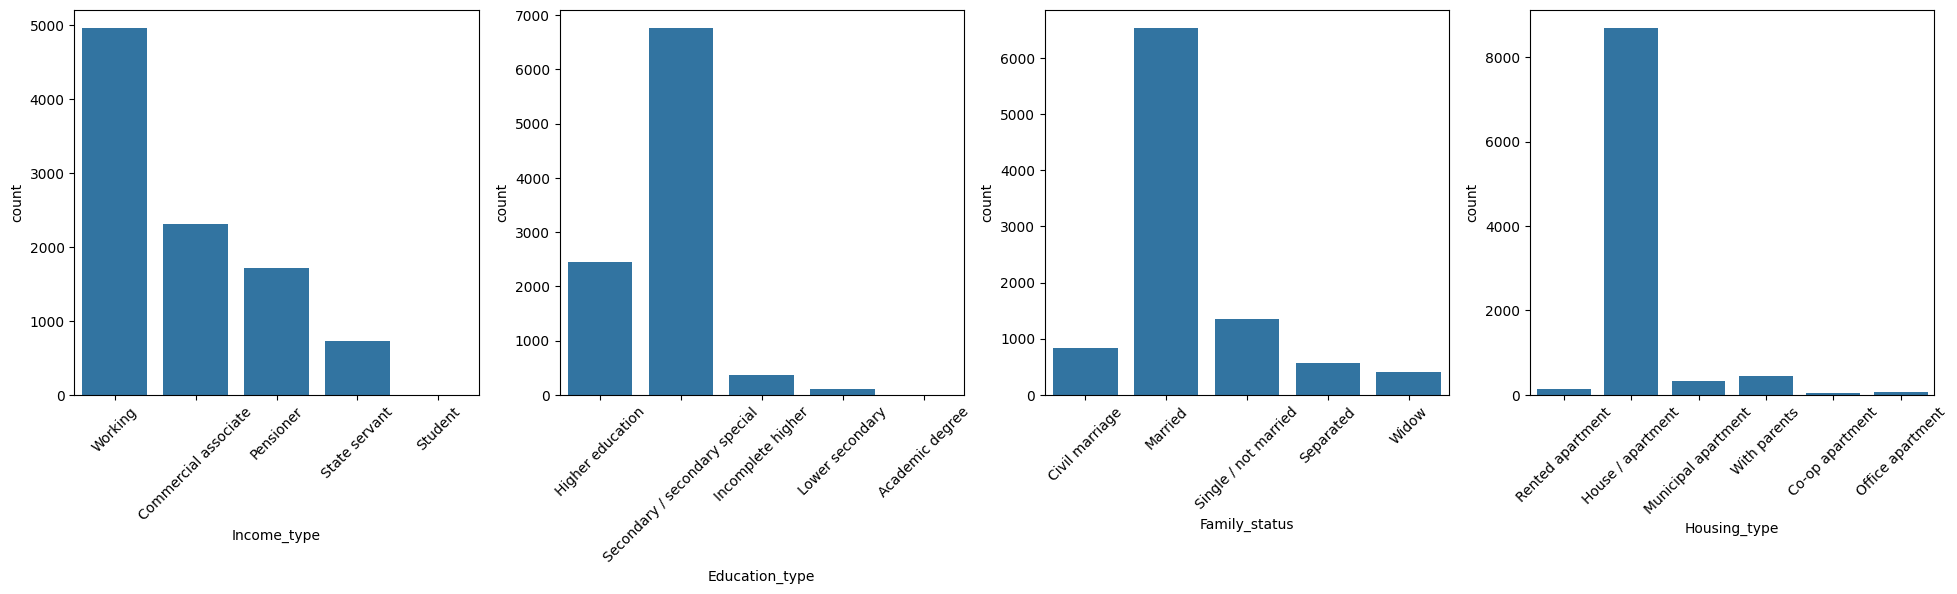

In [7]:

fig, ax = plt.subplots(1, 4, figsize=(24, 5))

sns.countplot(x='Income_type', data=df, ax=ax[0])
sns.countplot(x='Education_type', data=df, ax=ax[1])
sns.countplot(x='Family_status', data=df, ax=ax[2])
sns.countplot(x='Housing_type', data=df, ax=ax[3])

for i in range(4):
    ax[i].tick_params(axis='x', rotation=45)

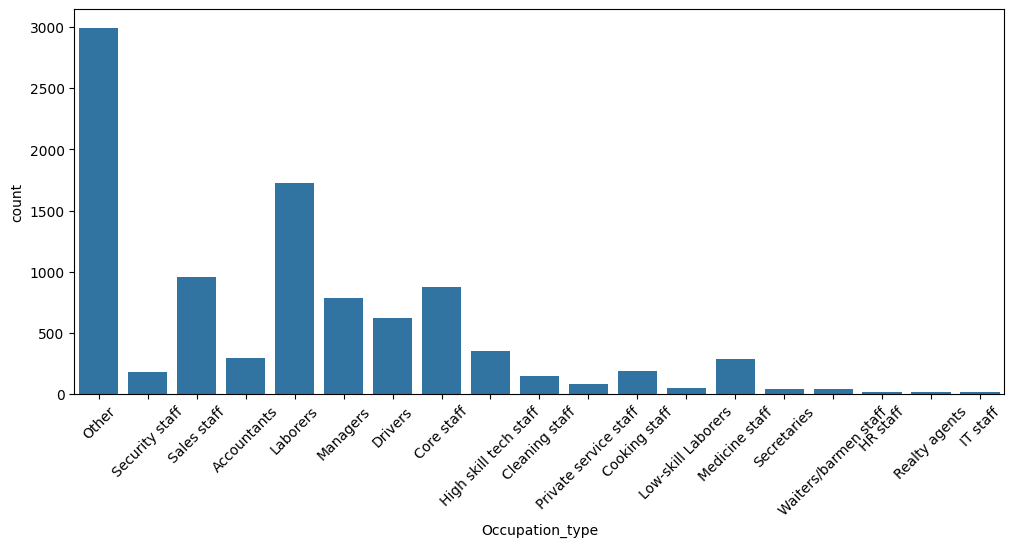

In [8]:
fig= plt.figure(figsize=(12, 5))

sns.countplot(x='Occupation_type', data=df)
# Rotate x-labels and do not show output except chart
_ = plt.xticks(rotation=45)

There isn't too much interesting from just the distributions of these categorical variables. The first four distributions do show distributions with a disproportionate amount of one type, with housing type in particular being incredibly heavily slanted. The Occupation_type distribution isn't particularly interesting at first glance, other than it isn't a distribution I might expect to have a median income of $112,500. This lends further credence to this not being US dollars.

Let's continue with a more in-depth analysis of some of the relationships

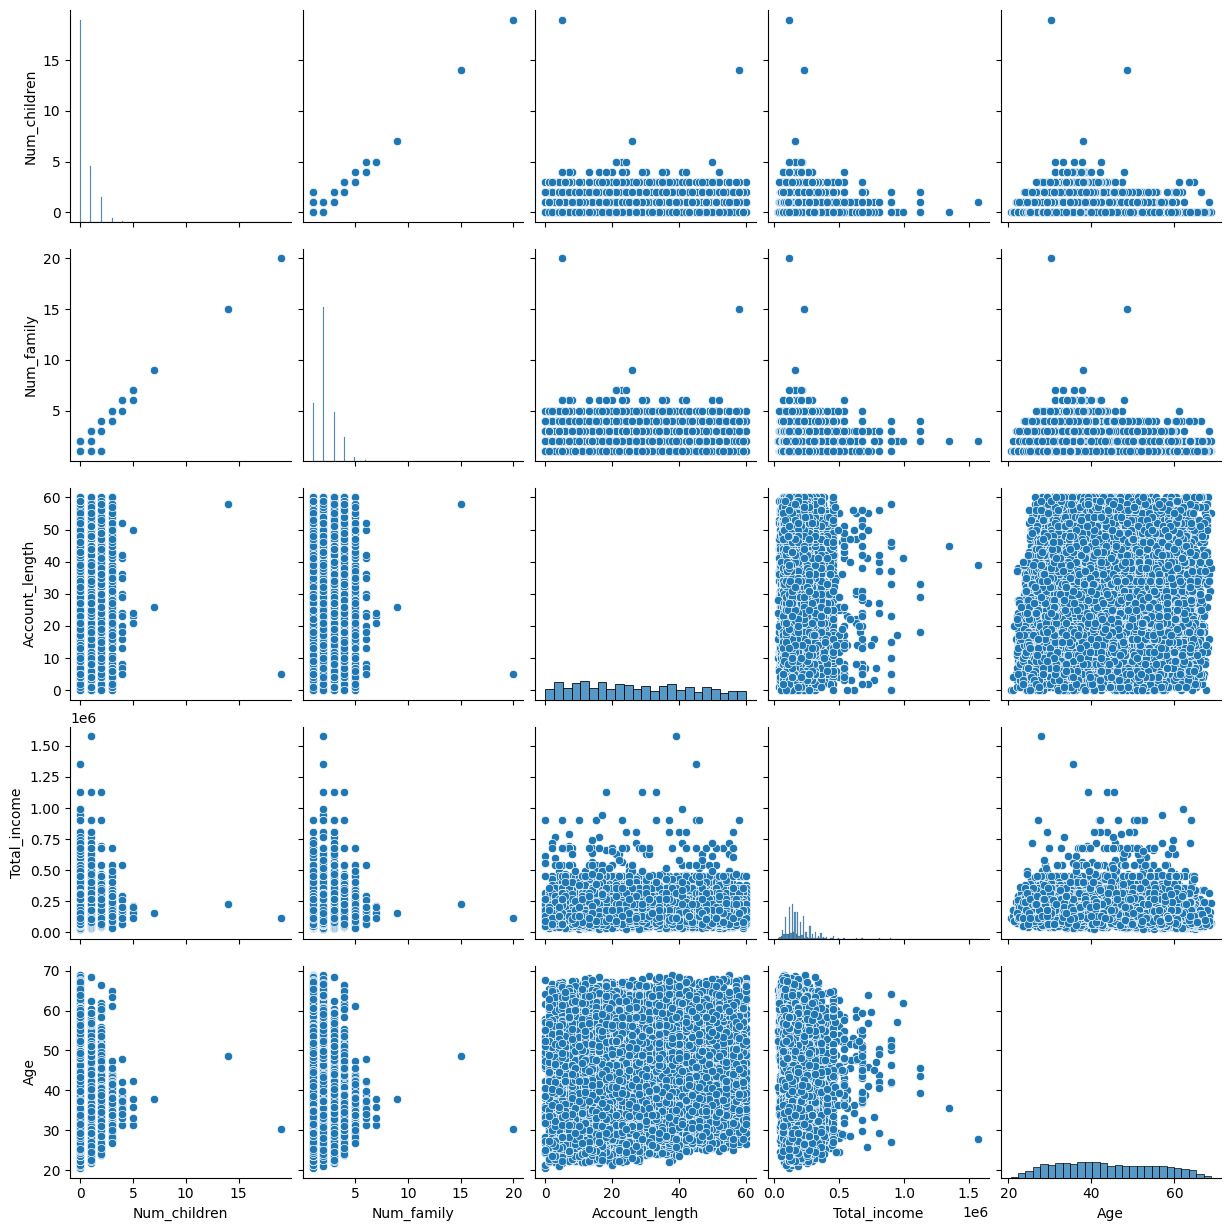

In [9]:
sns.pairplot(df[['Num_children', 'Num_family', 'Account_length', 'Total_income', 'Age']])

There isn't too much that is terribly interesting here. There are some outliers in terms of number of children and number of family members (which are understandably highly correlated) and in terms of income. If I wasn't planning on using a tree based model, I might be more worried about this. The more interesting thing is that I am pretty sure I am seeing somebody with and account age of 60 with an age of 25 or 30. Is the Age in years and the account age in months? Since I am going to do it anyways, I'll go ahead and add a feature that is the difference.

In [10]:
df['Age_when_account_opened'] = df['Age'] - df['Account_length']

<Axes: xlabel='Age_when_account_opened', ylabel='Count'>

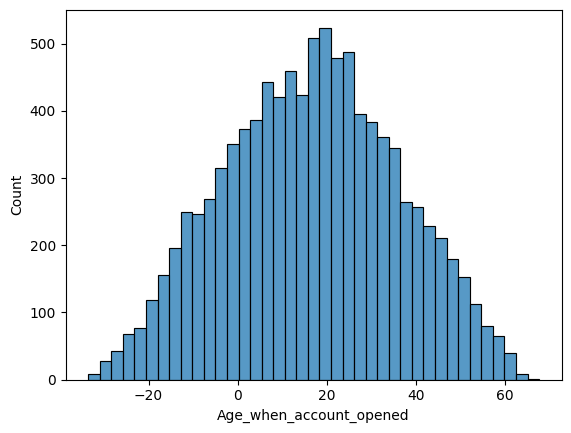

In [11]:
sns.histplot(df['Age_when_account_opened'])

<Axes: xlabel='Target', ylabel='Age_when_account_opened'>

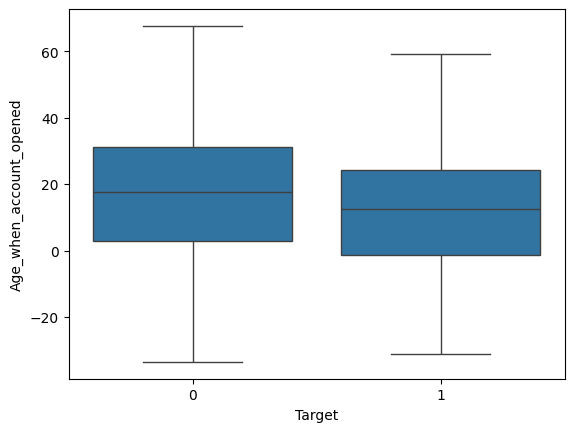

In [12]:
sns.boxplot(x='Target', y='Age_when_account_opened', data=df)

In [13]:
print(df.groupby('Target').agg({'Age_when_account_opened':'mean'}))
print(stats.ttest_ind(df[df['Target'] == 0]['Age_when_account_opened'], df[df['Target'] == 1]['Age_when_account_opened']))
print(df.loc[df['Age_when_account_opened']<=0,'Age_when_account_opened'].count())

        Age_when_account_opened
Target                         
0                     17.215447
1                     11.907565
TtestResult(statistic=9.147101931752307, pvalue=7.026284428515568e-20, df=9707.0)
2089


<Axes: xlabel='Age_when_account_opened', ylabel='Density'>

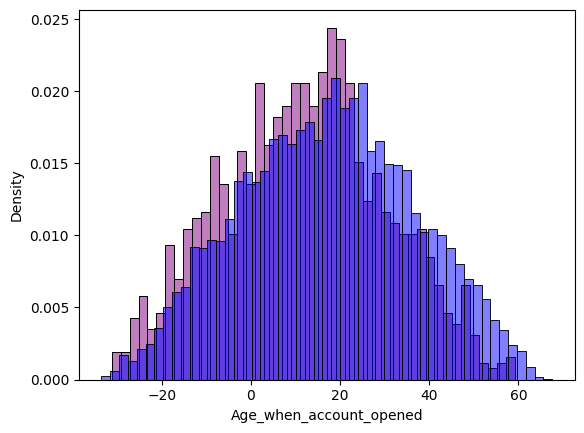

In [14]:
ax = plt.figure()
sns.histplot(df.loc[df['Target']==1,'Age_when_account_opened'], color = 'purple', alpha=0.5, binwidth=2, stat='density')
sns.histplot(df.loc[df['Target']==0,'Age_when_account_opened'], color = 'blue', alpha=0.5, binwidth=2, stat='density')

I struggle with what to make of this dataset at this point. There is a statitstically significant difference in the mean value, and the approved/rejected distributions look very similar, just shifted slightly. Let's see if this applies to other variables.

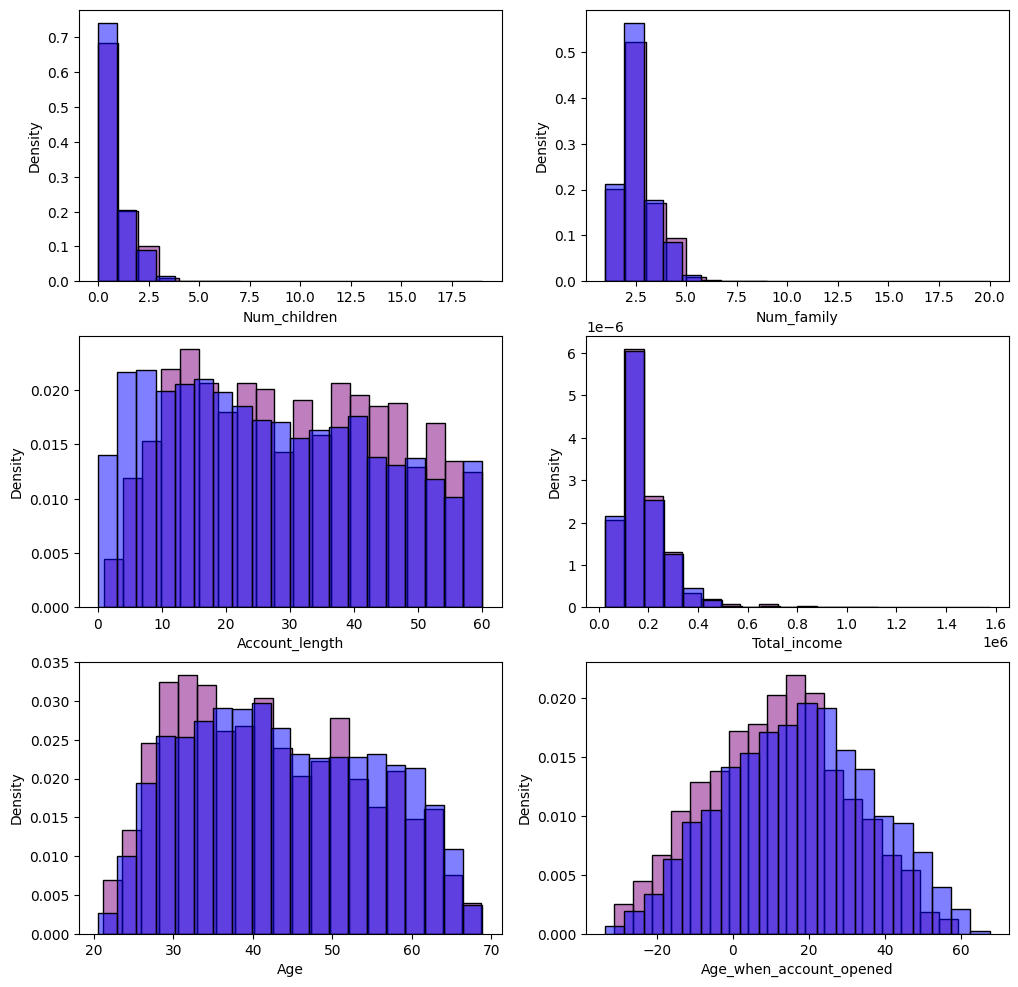

In [15]:
# Write code that creates a figure with six subplots in a 3x2 grid. Then iterate over the columns 'Num_children', 'Num_family', 'Account_length', 'Total_income', 'Age', and 'Age_when_account_opened' and plot a histogram of each column in a different subplot. Use 40 bins for each histogram.
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
columns = ['Num_children', 'Num_family', 'Account_length', 'Total_income', 'Age', 'Age_when_account_opened']
for i, col in enumerate(columns):
    #sns.histplot(df[col], bins=40, ax=ax[i//2, i%2])
    width = (df[col].max() - df[col].min())/20
    sns.histplot(df.loc[df['Target']==1,col], color = 'purple', alpha=0.5, binwidth=width, stat='density', ax=ax[i//2, i%2])
    sns.histplot(df.loc[df['Target']==0,col], color = 'blue', alpha=0.5, binwidth=width, stat='density', ax=ax[i//2, i%2])

In [16]:
for col in columns:
    print(f'{col} tests')
    print('Mann-Whitney U test: ', stats.mannwhitneyu(df.loc[df['Target'] == 0,col], df.loc[df['Target'] == 1, col]))
    print('Kolmogorov-Smirnov test: ', stats.ks_2samp(df.loc[df['Target'] == 0,col], df.loc[df['Target'] == 1, col]))

Num_children tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=5288595.0, pvalue=0.12048112564848662)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.020745922643401016, pvalue=0.7149207500691063, statistic_location=0, statistic_sign=1)
Num_family tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=5339332.5, pvalue=0.4401937623359963)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.013648416668223787, pvalue=0.9836567830726242, statistic_location=2, statistic_sign=1)
Account_length tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=4670131.0, pvalue=3.79931780783753e-15)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.0982565377291348, pvalue=8.243228820947575e-10, statistic_location=9, statistic_sign=1)
Total_income tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=5337229.0, pvalue=0.4658587268217508)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.016376120455576855, pvalue=0.920847979233662, statistic_location=189000.0, statistic_sign=1)
Age te

So overall, we see three first-order differences in our continuous and ordinal variables. First, Age_when_account_opened has the aformentioned shift. Second, there is a slightly higher rate of acceptances for relatively young people and a higher rate of rejection for older people. Third, people with low account_length (<10) are more likely to be rejected. These differences, and the lack of differences in other distributions, are confirmed by both of our chosen statistical tests.

In particular, let's check if the difference in distribution for age_when_account_opened is controlled by the rejection for account age.

<Axes: xlabel='Age_when_account_opened', ylabel='Density'>

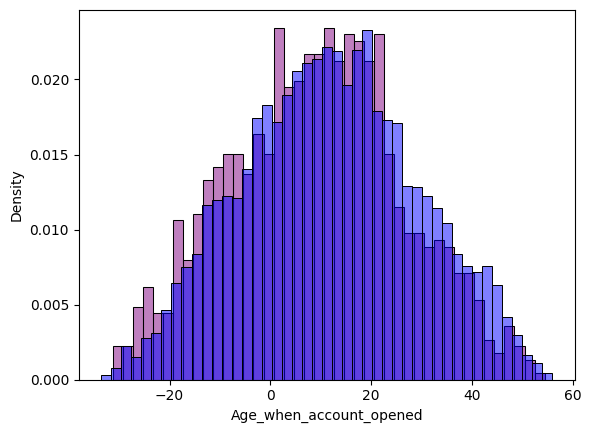

In [17]:
ax = plt.figure()
sns.histplot(df.loc[(df['Target']==1)&(df['Account_length']>10),'Age_when_account_opened'], color = 'purple', alpha=0.5, binwidth=2, stat='density')
sns.histplot(df.loc[(df['Target']==0)&(df['Account_length']>10),'Age_when_account_opened'], color = 'blue', alpha=0.5, binwidth=2, stat='density')

It is hard to tell precisely. It may have had some effect, but the difference between the distribution still remains. Let's continue to investigate with differences in the binary variables.

In [18]:
df[['Gender', 'Own_car', 'Own_property','Work_phone', 'Phone', 'Email', 'Unemployed','Target']].groupby('Target').mean()

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed
Target,,,,,,,
0,0.345953,0.368977,0.676715,0.217897,0.289343,0.086755,0.178376
1,0.367108,0.359314,0.637568,0.214341,0.276695,0.092751,0.150429


In [19]:
columns = ['Gender', 'Own_car', 'Own_property','Work_phone', 'Phone', 'Email', 'Unemployed']
for col in columns:
    print(f'{col} ztest:')
    print(proportions_ztest([df.loc[df['Target']==1, col].sum(), df.loc[df['Target']==0, col].sum()], [df[col].sum(), df.shape[0]-df[col].sum()]))

Gender ztest:
(-31.719473903452723, 8.37356380896899e-221)
Own_car ztest:
(-37.177233706047936, 1.5922290131395636e-302)
Own_property ztest:
(-163.8192342839417, 0.0)
Work_phone ztest:
(-10.974008945035033, 5.09616085877792e-28)
Phone ztest:
(-22.210846749212973, 2.6980504587040522e-109)
Email ztest:
(5.664246103407427, 1.476723371138819e-08)
Unemployed ztest:
(-7.2691706352592185, 3.6170127753830766e-13)


So it's one of those situations where, due to the large sample size, every one of a binary variables is statistically different. But looking at the acutal differences, they are probably too small to be significantly meaningful. However, we will definitely all of these in our first pass modeling. Let's now move on to the non-binary categorical variables.

In [20]:
df.columns
columns = ['Income_type', 'Education_type', 'Family_status', 'Housing_type', 'Occupation_type']
for col in columns:
    temp = df.groupby([col, 'Target']).agg({'ID':'count'}).reset_index()
    temp = temp.pivot(index='Target', columns=col, values='ID').reset_index().drop(columns=['Target'])
    # Drop a column if any of its values are less than 5
    temp = temp.loc[:,temp.columns[temp.min()>=5]]
    print(f'{col} Chi-Squared: ', stats.chi2_contingency(temp))
    

Income_type Chi-Squared:  Chi2ContingencyResult(statistic=2.4609572606540886, pvalue=0.48238831884302424, dof=3, expected_freq=array([[2006.62353184, 1485.87348032,  626.63589532, 4304.86709252],
       [ 305.37646816,  226.12651968,   95.36410468,  655.13290748]]))
Education_type Chi-Squared:  Chi2ContingencyResult(statistic=5.574135670268678, pvalue=0.13427111375208658, dof=3, expected_freq=array([[2132.62434299,  322.02019994,   98.94960322, 5868.40585386],
       [ 324.37565701,   48.97980006,   15.05039678,  892.59414614]]))
Family_status Chi-Squared:  Chi2ContingencyResult(statistic=8.26356038221152, pvalue=0.08238700372343694, dof=4, expected_freq=array([[ 725.52641879, 5667.09032856,  498.14852199, 1179.41435781,
         355.82037285],
       [ 110.47358121,  862.90967144,   75.85147801,  179.58564219,
          54.17962715]]))
Housing_type Chi-Squared:  Chi2ContingencyResult(statistic=4.828985606779703, pvalue=0.3052989429331711, dof=4, expected_freq=array([[7535.10904393,  2

Statistically, Family_status is bordering on significant, and education is also close. These variables may have some influence in our model. The other variables are questionable. I would still like to take a look at the occupation types, as with a high degree of freedom, there could be .

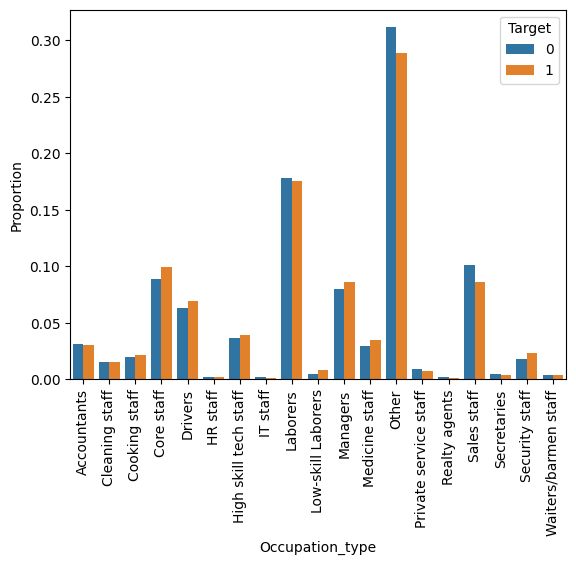

In [21]:
temp = df.groupby(['Occupation_type', 'Target']).agg({'ID':'count'}).reset_index()
# Convert the count in the ID column to a proportion of the total count for each target value
temp['ID'] = temp.groupby('Target')['ID'].transform(lambda x: x/x.sum())
temp = temp.rename(columns={'ID':'Proportion'})

sns.barplot(x='Occupation_type', y='Proportion', hue='Target', data=temp)
_ = plt.xticks(rotation=90)


Very little obvious difference. This concludes our examination of what is mostly the first_order interactions of variables the target variable. Next, we will look at some potential second order interactions and attempt further feature engineering.

The first thing I am interested in is something like total income divided by family members

In [22]:
df1 = df.copy()

In [23]:
df1['income_per_family_member'] = df1['Total_income'] / df1['Num_family']

Mann-Whitney U test:  MannwhitneyuResult(statistic=5399919.0, pvalue=0.9542622085668055)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.021514523117123093, pvalue=0.671949155098313, statistic_location=222750.0, statistic_sign=1)


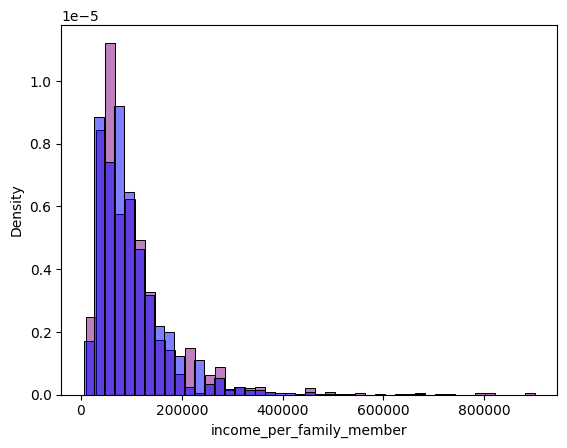

In [24]:
fig = plt.figure()
sns.histplot(df1.loc[(df1['Target']==1),'income_per_family_member'], color = 'purple', alpha=0.5, binwidth=20000, stat='density')
sns.histplot(df1.loc[(df1['Target']==0),'income_per_family_member'], color = 'blue', alpha=0.5, binwidth=20000, stat='density')
print('Mann-Whitney U test: ', stats.mannwhitneyu(df1.loc[df1['Target'] == 0,'income_per_family_member'], df1.loc[df1['Target'] == 1, 'income_per_family_member']))
print('Kolmogorov-Smirnov test: ', stats.ks_2samp(df1.loc[df1['Target'] == 0,'income_per_family_member'], df1.loc[df1['Target'] == 1, 'income_per_family_member']))


In [25]:
columns = ['Num_family', 'Account_length', 'Total_income', 'Age', 'Age_when_account_opened']
new_columns = []
temp = df.copy()
temp = temp.loc[temp['Num_family'] < 11,:]
for i in range(len(columns)):
    for j in range(i+1,len(columns)):

        c1 = columns[i]
        c2 = columns[j]
        temp[c1 + '_x_' + c2] = temp[c1] * temp[c2]
        temp[c1 + '_x_' + c2] = np.sqrt((temp[c1 + '_x_' + c2] - temp[c1 + '_x_' + c2].min()) / temp[c1 + '_x_' + c2].max())
        new_columns.append(c1 + '_x_' + c2)

temp = temp[new_columns + ['Target']]

for col in new_columns:
    print(f'{col} tests')
    print('Mann-Whitney U test: ', stats.mannwhitneyu(temp.loc[temp['Target'] == 0,col], temp.loc[temp['Target'] == 1, col]))
    print('Kolmogorov-Smirnov test: ', stats.ks_2samp(temp.loc[temp['Target'] == 0,col], temp.loc[temp['Target'] == 1, col]))

Num_family_x_Account_length tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=4739650.0, pvalue=1.201076704066188e-12)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.09329170487913019, pvalue=6.932905030958785e-09, statistic_location=0.35805743701971643, statistic_sign=1)
Num_family_x_Total_income tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=5292262.5, pvalue=0.23173733411576103)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.02880942176863195, pvalue=0.30720706829868333, statistic_location=0.19364916731037085, statistic_sign=1)
Num_family_x_Age tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=5584137.0, pvalue=0.05404441483520045)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.04515491869350014, pvalue=0.02061029979009328, statistic_location=0.4378840076468942, statistic_sign=-1)
Num_family_x_Age_when_account_opened tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=6160481.0, pvalue=5.96214555813577e-16)
Kolmogorov-Smirnov test:  KstestRes

<Axes: xlabel='Total_income_x_Age_when_account_opened', ylabel='Density'>

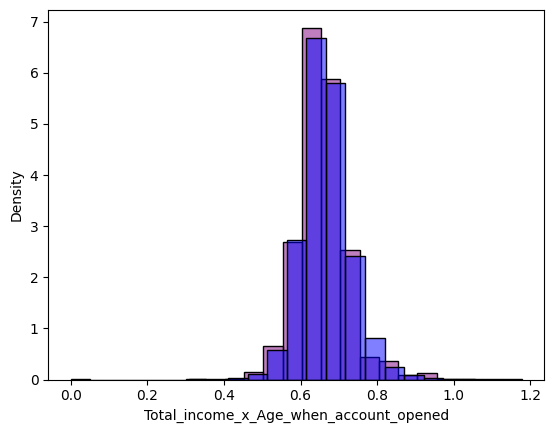

In [26]:
ax = plt.figure()
sns.histplot(temp.loc[(temp['Target']==1),'Total_income_x_Age_when_account_opened'], color = 'purple', alpha=0.5, binwidth=0.05, stat='density')
sns.histplot(temp.loc[(temp['Target']==0),'Total_income_x_Age_when_account_opened'], color = 'blue', alpha=0.5, binwidth=0.05, stat='density')

So, what we see at this point, we are not seeing meaningful interaction between our between our variables. We could potentially continue evaluating like this using different functions and combinations. However, but at this point, with no obvious features to engineering, we may want to just turn to the machine learning model and see if we can refine features based on interactions that we see there. Let's start with the classic tree, going ahead and splitting a test set.

In [27]:
df = pd.get_dummies(df, drop_first=True)

for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

In [28]:
X = df.drop(columns=['ID', 'Target'])
y = df[['Target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
clf = cat.CatBoostClassifier(iterations=250, learning_rate=0.01, depth=8, verbose=100, random_state=42)

cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')

print(cv)

0:	learn: 0.6859468	total: 49ms	remaining: 12.2s
100:	learn: 0.4089830	total: 193ms	remaining: 284ms


200:	learn: 0.3698787	total: 344ms	remaining: 83.9ms
249:	learn: 0.3603492	total: 427ms	remaining: 0us
0:	learn: 0.6859702	total: 2.43ms	remaining: 605ms
100:	learn: 0.4083790	total: 156ms	remaining: 230ms
200:	learn: 0.3678791	total: 319ms	remaining: 77.7ms
249:	learn: 0.3589459	total: 393ms	remaining: 0us
0:	learn: 0.6860016	total: 4.27ms	remaining: 1.06s
100:	learn: 0.4084169	total: 202ms	remaining: 298ms
200:	learn: 0.3690950	total: 349ms	remaining: 85ms
249:	learn: 0.3601622	total: 420ms	remaining: 0us
0:	learn: 0.6859261	total: 5.41ms	remaining: 1.34s
100:	learn: 0.4086711	total: 171ms	remaining: 252ms
200:	learn: 0.3688576	total: 317ms	remaining: 77.2ms
249:	learn: 0.3602191	total: 391ms	remaining: 0us
0:	learn: 0.6859264	total: 4.22ms	remaining: 1.05s
100:	learn: 0.4090244	total: 196ms	remaining: 289ms
200:	learn: 0.3692244	total: 349ms	remaining: 85.1ms
249:	learn: 0.3613551	total: 421ms	remaining: 0us
[0.59310058 0.6055105  0.59126077 0.58156619 0.59077224]


This is both interesting and unfortunate. Our model appears to be very weak, indicating that there is not strong information contained in this data set. Let's see what we can find from analyzing a produced model

In [30]:
clf.fit(X_train, y_train)

clf.get_feature_importance(prettified=True)

0:	learn: 0.6859824	total: 2.48ms	remaining: 617ms
100:	learn: 0.4092291	total: 166ms	remaining: 244ms
200:	learn: 0.3717434	total: 325ms	remaining: 79.1ms
249:	learn: 0.3634860	total: 405ms	remaining: 0us


,Feature Id,Importances
0,Account_length,13.823311
1,Age_when_account_opened,11.011251
2,Years_employed,8.757004
3,Total_income,7.577813
4,Age,7.358045
5,Num_family,5.617042
6,Num_children,4.550825
7,Family_status_Single / not married,3.580007
8,Own_property,3.383633
9,Own_car,3.117932


In [31]:
X_train.dtypes

Gender                                            int64
Own_car                                           int64
Own_property                                      int64
Work_phone                                        int64
Phone                                             int64
Email                                             int64
Unemployed                                        int64
Num_children                                      int64
Num_family                                        int64
Account_length                                    int64
Total_income                                    float64
Age                                             float64
Years_employed                                  float64
Age_when_account_opened                         float64
Income_type_Pensioner                             int64
Income_type_State servant                         int64
Income_type_Student                               int64
Income_type_Working                             

In [42]:
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_train)

TypeError: TreeExplainer.__call__() got an unexpected keyword argument 'max_display'

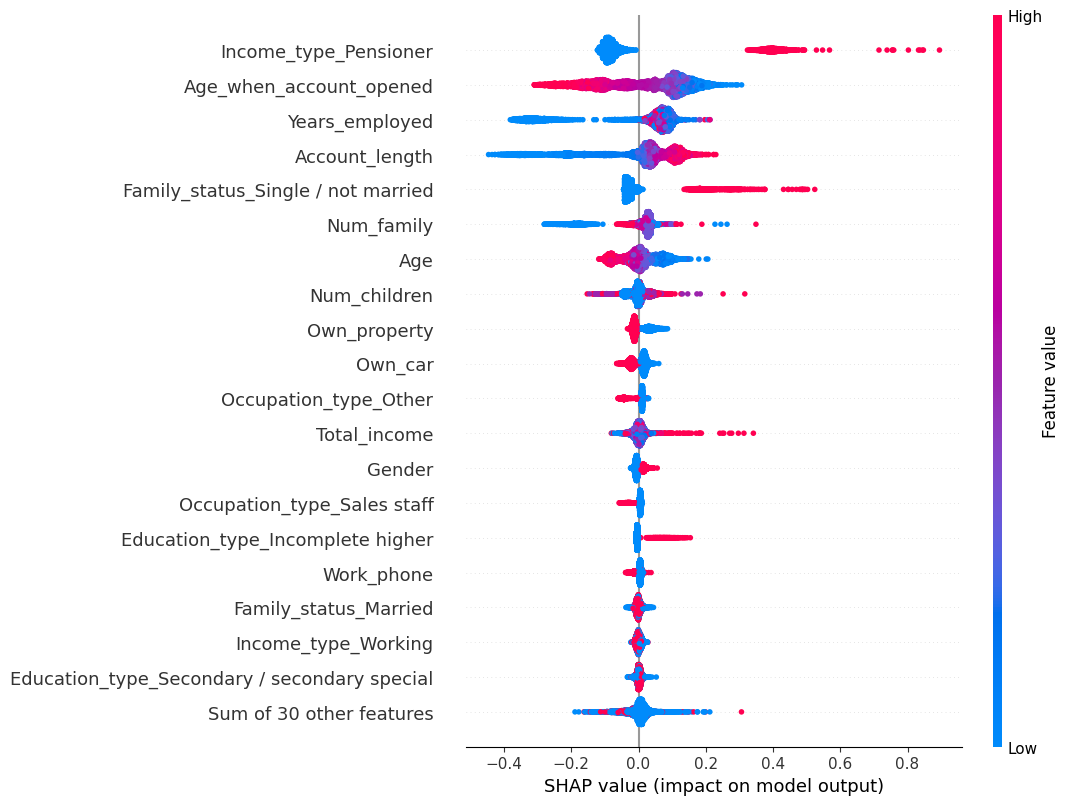

In [43]:
type(shap_values)
shap.plots.beeswarm(shap_values, max_display=20)

In [52]:
explainer = shap.Explainer(clf, feature_perturbation='tree_path_dependent')
shap_values = explainer(X_train)
shap_interaction_values = explainer.shap_interaction_values(X_train)



In [63]:
shap_interaction_values[0].shape

vals = []
inds = []
for i in range(0,shap_interaction_values[0].shape[0]):
    for j in range(i,shap_interaction_values[0].shape[1]):
        #print(i)
        vals.append(abs(shap_interaction_values[0][i, j]))
        inds.append((i, j))

a = pd.DataFrame({'vals':vals, 'inds':inds}).sort_values('vals', ascending=False)
a.head(20)

,vals,inds
595,0.410609,"(14, 14)"
559,0.214231,"(13, 13)"
524,0.150679,"(12, 14)"
405,0.121635,"(9, 9)"
484,0.059616,"(11, 11)"
364,0.035915,"(8, 8)"
97,0.029206,"(2, 2)"
623,0.027528,"(14, 42)"
522,0.022182,"(12, 12)"
487,0.018102,"(11, 14)"


In [64]:
list(enumerate(clf.feature_names_))

[(0, 'Gender'),
 (1, 'Own_car'),
 (2, 'Own_property'),
 (3, 'Work_phone'),
 (4, 'Phone'),
 (5, 'Email'),
 (6, 'Unemployed'),
 (7, 'Num_children'),
 (8, 'Num_family'),
 (9, 'Account_length'),
 (10, 'Total_income'),
 (11, 'Age'),
 (12, 'Years_employed'),
 (13, 'Age_when_account_opened'),
 (14, 'Income_type_Pensioner'),
 (15, 'Income_type_State servant'),
 (16, 'Income_type_Student'),
 (17, 'Income_type_Working'),
 (18, 'Education_type_Higher education'),
 (19, 'Education_type_Incomplete higher'),
 (20, 'Education_type_Lower secondary'),
 (21, 'Education_type_Secondary / secondary special'),
 (22, 'Family_status_Married'),
 (23, 'Family_status_Separated'),
 (24, 'Family_status_Single / not married'),
 (25, 'Family_status_Widow'),
 (26, 'Housing_type_House / apartment'),
 (27, 'Housing_type_Municipal apartment'),
 (28, 'Housing_type_Office apartment'),
 (29, 'Housing_type_Rented apartment'),
 (30, 'Housing_type_With parents'),
 (31, 'Occupation_type_Cleaning staff'),
 (32, 'Occupation_type

With this, we have a much more intricate work around around interactions in our work. While this does not tell us the form of any of the interactions, it does give us a place to start and a relative indication of how important interactions are relative to the effects of individual variables. Tomorrow we will continue with investigating the effects and seeing if we can engineer better features.